In [1]:
import pickle
import pandas as pd

with open('../../data/model_comp/pos_pred_result/pos_result_list_random.pkl', 'rb') as f:
    pos_result_list = pickle.load(f)

with open('../../data/model_comp/neg_pred_result/neg_result_list_random.pkl', 'rb') as f:
    neg_result_list = pickle.load(f)

In [2]:
df_pos = pd.DataFrame(pos_result_list, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['kNN', 'RF', 'SVM', 'XGB', 'NN']).\
    reset_index().rename(columns={'index':'ML'}).melt(id_vars='ML', var_name='score')

df_neg = pd.DataFrame(neg_result_list, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['kNN', 'RF', 'SVM', 'XGB', 'NN']).\
    reset_index().rename(columns={'index':'ML'}).melt(id_vars='ML', var_name='score')

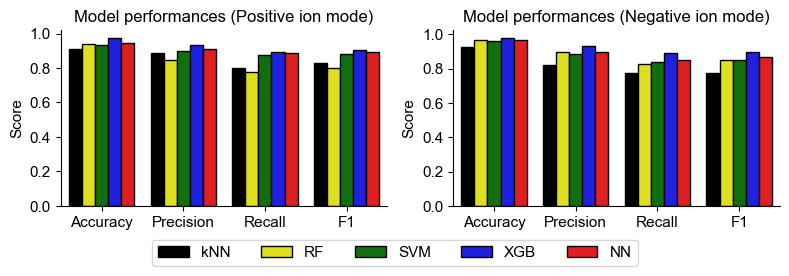

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

arial_path = '../../arial.ttf'
arial = fm.FontProperties(fname=arial_path, size=11)

fig, axs = plt.subplots(1, 2, figsize=(8, 2.5)) 

color = ['black', 'yellow', 'green', 'blue', 'red']

sns.barplot(data=df_pos, x='score', y='value', hue='ML', palette=color, ax=axs[0], edgecolor="0")
axs[0].set_title('Model performances (Positive ion mode)', fontproperties=arial, fontsize=12)
axs[0].set_xlabel('')
axs[0].set_ylabel('Score', fontproperties=arial)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_legend().remove()
for label in axs[0].get_xticklabels():
    label.set_fontproperties(arial)
for label in axs[0].get_yticklabels():
    label.set_fontproperties(arial)

sns.barplot(data=df_neg, x='score', y='value', hue='ML', palette=color, ax=axs[1], edgecolor="0")
axs[1].set_title('Model performances (Negative ion mode)', fontproperties=arial, fontsize=12)
axs[1].set_xlabel('')
axs[1].set_ylabel('Score', fontproperties=arial)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_legend().remove()
for label in axs[1].get_xticklabels():
    label.set_fontproperties(arial)
for label in axs[1].get_yticklabels():
    label.set_fontproperties(arial)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title='',
    title_fontproperties=arial, 
    fontsize=10,
    prop=arial,
    bbox_to_anchor=(0.5, 0.05), 
    loc='upper center',     
    ncol=5                   

plt.tight_layout()
plt.savefig('../../data/model_comp/model_performances.svg', dpi=300)
plt.show()

pred result

In [5]:
df_pos2x = pd.read_csv('../../data/basedata/df_pos_MCH.csv')
from sklearn.model_selection import train_test_split
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_pos2x.drop(columns=columns_to_drop).astype(float).values
y = df_pos2x['Ontology']
print(len(y.unique()))
X_train, X_test_pos, y_train, y_test_pos = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_neg2x = pd.read_csv('../../data/basedata/df_neg_MCH.csv')
from sklearn.model_selection import train_test_split
X = df_neg2x.drop(columns=columns_to_drop).astype(float).values
y = df_neg2x['Ontology']
print(len(y.unique()))
X_train, X_test_neg, y_train, y_test_neg = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

63
69


In [6]:
import joblib

best_xgb_model_pos = joblib.load('../../data/model_comp/pos_pred_result/best_xgb_model_random_pos.joblib')
best_xgb_model_neg = joblib.load('../../data/model_comp/neg_pred_result/best_xgb_model_random_neg.joblib')
label_encoder_pos = joblib.load('../../data/model_comp/pos_pred_result/label_encoder_pos_random.pkl')
number_to_class_pos = {index: label for index, label in enumerate(label_encoder_pos.classes_)}
label_encoder_neg = joblib.load('../../data/model_comp/neg_pred_result/label_encoder_neg_random.pkl')
number_to_class_neg = {index: label for index, label in enumerate(label_encoder_neg.classes_)}

In [7]:
y_pred_prob_xgb_pos = best_xgb_model_pos.predict_proba(X_test_pos)
y_pred_prob_xgb_neg = best_xgb_model_neg.predict_proba(X_test_neg)

In [9]:
def create_pred_class(row):
    classes = [f"{col}:{round(value, 3)}" for col, value in sorted(row.items(), key=lambda x: x[1], reverse=True) if value >= 0.01] #1%
    return ','.join(classes)

def check_ontology_in_pred_class(row):
    ontology = row['correctclass']
    predclass = row['predclass']
    return ontology in predclass

In [10]:
#pos
df_pos_predres = pd.DataFrame(y_pred_prob_xgb_pos).rename(columns=number_to_class_pos)
df_pos_predres['pred1st'] = df_pos_predres.idxmax(axis=1)
df_pos_predres['predclass'] = df_pos_predres.drop('pred1st', axis=1).apply(create_pred_class, axis=1)
df_pos_predres['prednumber'] = df_pos_predres['predclass'].apply(lambda x: len(x.split(',')))

df_pos_result = df_pos_predres[['pred1st', 'predclass', 'prednumber']].\
    merge(pd.DataFrame(y_test_pos).reset_index(drop=True).rename(columns={'Ontology':'correctclass'}), left_index=True, right_index=True)

df_pos_result['candidates'] = df_pos_result.apply(check_ontology_in_pred_class, axis=1)

all_pos = len(df_pos_result)
pred1st_pos = len(df_pos_result[df_pos_result['pred1st'] == df_pos_result['correctclass']])
candidates_pos = len(df_pos_result[df_pos_result['candidates'] == True])
false_pos = len(df_pos_result[df_pos_result['candidates'] == False])


#neg
df_neg_predres = pd.DataFrame(y_pred_prob_xgb_neg).rename(columns=number_to_class_neg)
df_neg_predres['pred1st'] = df_neg_predres.idxmax(axis=1)
df_neg_predres['predclass'] = df_neg_predres.drop('pred1st', axis=1).apply(create_pred_class, axis=1)
df_neg_predres['prednumber'] = df_neg_predres['predclass'].apply(lambda x: len(x.split(',')))

df_neg_result = df_neg_predres[['pred1st', 'predclass', 'prednumber']].\
    merge(pd.DataFrame(y_test_neg).reset_index(drop=True).rename(columns={'Ontology':'correctclass'}), left_index=True, right_index=True)

df_neg_result['candidates'] = df_neg_result.apply(check_ontology_in_pred_class, axis=1)

all_neg = len(df_neg_result)
pred1st_neg = len(df_neg_result[df_neg_result['pred1st'] == df_neg_result['correctclass']])
candidates_neg = len(df_neg_result[df_neg_result['candidates'] == True])
false_neg = len(df_neg_result[df_neg_result['candidates'] == False])

In [24]:
df_neg2x_test = df_neg2x[columns_to_drop].iloc[y_test_neg.index].reset_index().rename(columns={'index':'ID'})[['dataset', 'ID', 'Metabolitename', 'Ontology']]
df_neg_test_res = pd.concat([df_neg2x_test, df_neg_result[['pred1st', 'predclass']]], axis=1)
df_neg_test_res['ionmode'] = 'Negative'

In [25]:
df_pos2x_test = df_pos2x[columns_to_drop].iloc[y_test_pos.index].reset_index().rename(columns={'index':'ID'})[['dataset', 'ID', 'Metabolitename', 'Ontology']]
df_pos_test_res = pd.concat([df_pos2x_test, df_pos_result[['pred1st', 'predclass']]], axis=1)
df_pos_test_res['ionmode'] = 'Positive'

In [30]:
df_test_res = pd.concat([df_neg_test_res, df_pos_test_res], axis=0)
df_test_res.to_csv('../../data/model_comp/test_result.csv', index=False)

In [27]:
df_pos_result.set_index(y_test_pos.index).to_csv('../../data/model_comp/pos_pred_result/df_pos_result_random.csv')
df_neg_result.set_index(y_test_neg.index).to_csv('../../data/model_comp/neg_pred_result/df_neg_result_random.csv')

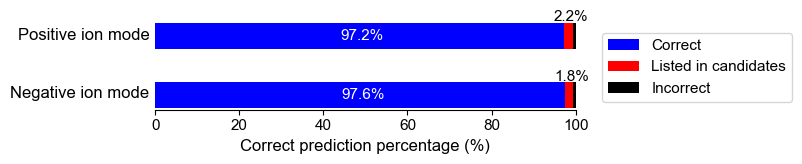

In [66]:
import matplotlib.pyplot as plt
#pos
test_pred_1st_pos = round(pred1st_pos/all_pos * 100, 1)
test_pred_candidate_pos = round(candidates_pos/all_pos * 100, 1)
percentages_pos = [test_pred_1st_pos, test_pred_candidate_pos-test_pred_1st_pos, 100-test_pred_candidate_pos]
percentages2_pos = [test_pred_1st_pos, round(test_pred_candidate_pos-test_pred_1st_pos, 1), ]
categories = ["Correct", "Listed in candidates", "Incorrect"]

#neg
test_pred_1st_neg = round(pred1st_neg/all_neg * 100, 1)
test_pred_candidate_neg = round(candidates_neg/all_neg * 100, 1)
percentages_neg = [test_pred_1st_neg, test_pred_candidate_neg-test_pred_1st_neg, 100-test_pred_candidate_neg]
percentages2_neg = [test_pred_1st_neg, round(test_pred_candidate_neg-test_pred_1st_neg, 1), ]

#font
arial_path = '../../arial.ttf'
arial = fm.FontProperties(fname=arial_path, size=11)

bar_width = 0.8
color = ['blue', 'red', 'black']

fig, axs = plt.subplots(2, 1, figsize=(6.2, 1.8)) 
plt.subplots_adjust(hspace=0)

#plot1
bar_centers = [percentages_pos[0]/2, percentages_pos[0] + percentages_pos[1]/2, percentages_pos[0] + percentages_pos[1] + percentages_pos[2]/2]
bars = axs[0].barh(1, percentages_pos[0], height=bar_width, color=color[0], label='Correct')
axs[0].barh(1, percentages_pos[1], left=percentages_pos[0], height=bar_width, color=color[1], label='Listed in candidates')
axs[0].barh(1, percentages_pos[2], left=percentages_pos[0] + percentages_pos[1], height=bar_width, color=color[2], label='Incorrect')

for i, (category, center, percentage) in enumerate(zip(categories, bar_centers, percentages2_pos)):
    if i == 0:
        axs[0].text(center + 0.7, 1, f'{percentage}%', ha='center', va='center', fontsize=11, color='white', fontproperties=arial)
    elif i == 1:
        axs[0].text(center + 0.7, 1 + 0.57, f'{percentage}%', ha='center', va='center', fontsize=11, color='black', fontproperties=arial)

axs[0].set_yticks([])
axs[0].set_xlim(0, 100)
axs[0].legend().remove()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].xaxis.set_ticks([])
axs[0].set_ylabel('Positive ion mode', fontsize=12, rotation=0, fontproperties=arial)
axs[0].yaxis.set_label_coords(-0.17, 0.25)  

#plot2
bar_centers = [percentages_neg[0]/2, percentages_neg[0] + percentages_neg[1]/2, percentages_neg[0] + percentages_neg[1] + percentages_neg[2]/2]
bars = axs[1].barh(1, percentages_neg[0], height=bar_width, color=color[0], label='Correct')
axs[1].barh(1, percentages_neg[1], left=percentages_neg[0], height=bar_width, color=color[1], label='Listed in candidates')
axs[1].barh(1, percentages_neg[2], left=percentages_neg[0] + percentages_neg[1], height=bar_width, color=color[2], label='Incorrect')

for i, (category, center, percentage) in enumerate(zip(categories, bar_centers, percentages2_neg)):
    if i == 0:
        axs[1].text(center + 0.7, 1, f'{percentage}%', ha='center', va='center', fontsize=11, color='white', fontproperties=arial)
    elif i == 1:
        axs[1].text(center + 0.7, 1 + 0.55, f'{percentage}%', ha='center', va='center', fontsize=11, color='black', fontproperties=arial)

axs[1].set_xlabel('Correct prediction percentage (%)', fontsize=12, fontproperties=arial)
axs[1].set_ylabel('Negative ion mode', fontsize=12, rotation=0, fontproperties=arial)
axs[1].yaxis.set_label_coords(-0.18, 0.3)  
axs[1].set_yticks([])
axs[1].set_xlim(0, 100)
axs[1].set_title('', fontsize=18)
axs[1].legend().remove()

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

for label in axs[1].get_xticklabels():
    label.set_fontproperties(arial)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title='',
    title_fontproperties=arial, 
    fontsize=10,
    prop=arial,
    bbox_to_anchor=(1.15, 0.8),  
    loc='upper center',         
    ncol=1                     
)

plt.tight_layout()
plt.savefig('../../data/model_comp/model_score.svg', dpi=300)
plt.show()